# Perkenalan

In [1]:
'''
=================================================
Graded Challengge 07 phase 2

Nama  : Dendy Dwinanda
Batch : RMT-030

Program ini dibuat untuk melakukan prediksi pada
pasien yang tidak sehat dan sehat berdasarkan hasil
brain CT dengan computer vision.

Analisis SMART :
- Spesific = Membuat prediksi pada pasien yang tidak
sehat dan sehat berdasarkan hasil brain CT dengan
computer vision.

- Measurable = Menganalisa hasil brain CT untuk
diagnosis awal pasien tentang kondisi kesehatannya.

- Achievable = Medapatkan hasil prediksi dari setiap
data hasil brain ct untuk diagnosis awal.

- Relevant = Membantu bagian terkait untuk melihat
prediksi hasil brain ct pasien guna diagnosis awal.

- Time-bound = Model prediksi akan dievaluasi dalam 3
bulan kedepan untuk meningkatkan akurasi analisa.

=================================================
'''

'\n=================================================\nGraded Challengge 07 phase 2\n\nNama  : Dendy Dwinanda\nBatch : RMT-030\n\nProgram ini dibuat untuk melakukan prediksi pada\npasien yang tidak sehat dan sehat berdasarkan hasil\nbrain CT dengan computer vision.\n\nAnalisis SMART :\n- Spesific = Membuat prediksi pada pasien yang tidak\nsehat dan sehat berdasarkan hasil brain CT dengan\ncomputer vision.\n\n- Measurable = Menganalisa hasil brain CT untuk\ndiagnosis awal pasien tentang kondisi kesehatannya.\n\n- Achievable = Medapatkan hasil prediksi dari setiap\ndata hasil brain ct untuk diagnosis awal.\n\n- Relevant = Membantu bagian terkait untuk melihat\nprediksi hasil brain ct pasien guna diagnosis awal.\n\n- Time-bound = Model prediksi akan dievaluasi dalam 3\nbulan kedepan untuk meningkatkan akurasi analisa.\n\n=================================================\n'

# Import Libraries

In [2]:
!pip install split-folders
!pip install gdown

In [3]:
import os
import splitfolders
import pathlib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gdown
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')


# Data Loading

In [4]:
# Install Kaggle library in Google Collaboratory

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 97% 104M/107M [00:01<00:00, 64.5MB/s] 
100% 107M/107M [00:01<00:00, 77.3MB/s]
CPU times: user 34.9 ms, sys: 8.05 ms, total: 42.9 ms
Wall time: 3.45 s


In [6]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip /content/brian-tumor-dataset.zip

Archive:  /content/brian-tumor-dataset.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: B

In [7]:
# Dataset Path
data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/content/working/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:00, 5761.97 files/s]


In [8]:
# Define path

main_path = '/content/brain'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'val')

In [9]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - Healthy : 1669
Total Data - Brain Tumor : 2010

Test Path
Total Data - Healthy : 418
Total Data - Brain Tumor : 503



# Exploratory Data Analysis

X-Ray bekerja dengan cara sebagai berikut:
- Sinar X-Ray yang terpancar akan masuk kedalam tubuh, apabila mengenai logam atau organ tubuh sinar akan terblokir. Sinar yang terblokir tersebut akan menghasilkan warna putih.
- Hasil foto akan berwarna abu-abu apabila sinar-X mengenai bagian organ seperti otot, lemak, dan cairan.
- Sinar-X yang terkena cahaya akan menghasilkan warna hitam pada hasil foto.
- Dalam mesin X-Ray terdapat sebuah tabung sinar X yang di dalamnya terdapat elektroda yang menghasilkan elektron. Elektron yang dihasilkan kemudian dipercepat oleh medan listrik menuju anoda dan menghasilkan sinar X. Sinar X yang dihasilkan keluar melalui tutup tabung dan akan ditujukan ke objek yang akan diambil fotonya.
- Sinar X yang bersentuhan dengan jaringan tubuh akan menampilkan hasil berupa gambar. Jadi, sinar X dapat terserap oleh beda padat di dalam tubuh. Selama pemeriksaan X-ray, mesin akan mengirimkan gelombang radiasi elektromagnetik untuk memindai kondisi organ tubuh bagian dalam.

In [10]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  Healthy


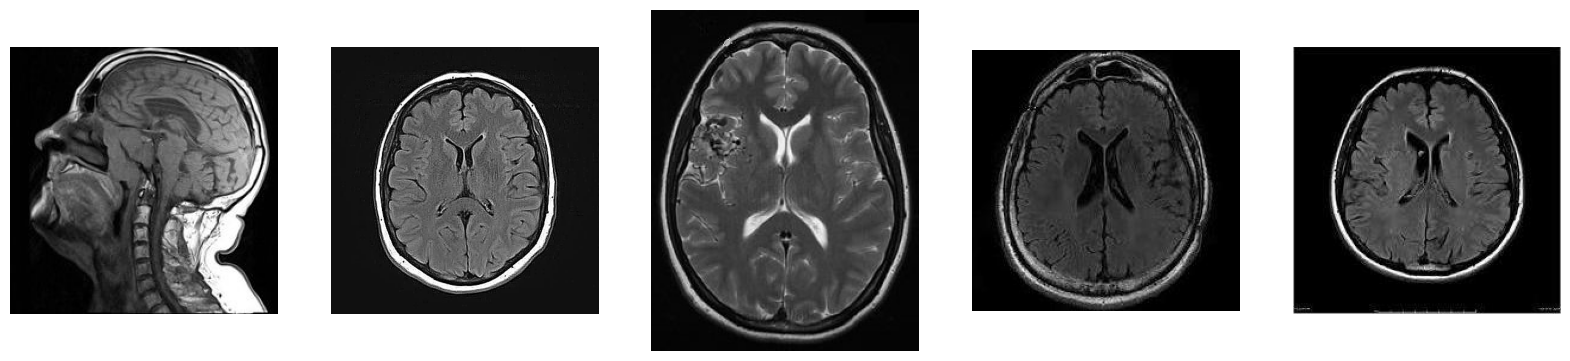

Class :  Brain Tumor


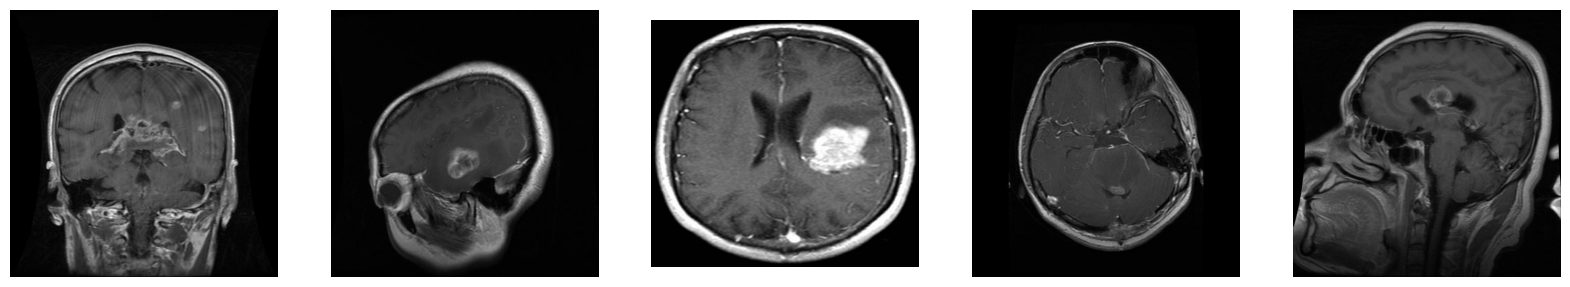

In [11]:
# Visualization of train_path

plot_images(train_path)

CT scan wajah dan kepala hasil normal:

- Otak, pembuluh darah, tengkorak, dan wajah memiliki ukuran, bentuk dan posisi yang normal.
- Tidak ada benda asing yang tumbuh atau menetap.
- Tidak terjadi perdarahan.

CT scan wajah dan kepala hasil abnormal:

- Pertumbuhan tumor atau  atau pendarahan terjadi pada otak.


# Feature Engineering

## Hyperparameter

In [12]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

## Split train set dan Val Set

In [13]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 2208 images belonging to 2 classes.
Found 1471 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


In [14]:
train_set.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

# ANN training

In [15]:
# Clear session

seed = 10
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Model Definition

In [16]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid',
                kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 179776)            0         
                                                                 
 dropout (Dropout)           (None, 179776)            0

## Model Training

In [17]:
# Train the model

%%time
history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
35/35 [==============================] - 32s 526ms/step - loss: 4.3123 - accuracy: 0.6454 - val_loss: 1.4057 - val_accuracy: 0.7199
Epoch 2/20
35/35 [==============================] - 10s 288ms/step - loss: 0.9766 - accuracy: 0.7812 - val_loss: 1.2120 - val_accuracy: 0.5738
Epoch 3/20
35/35 [==============================] - 11s 323ms/step - loss: 0.7360 - accuracy: 0.8007 - val_loss: 0.9175 - val_accuracy: 0.6540
Epoch 4/20
35/35 [==============================] - 10s 299ms/step - loss: 0.6904 - accuracy: 0.8483 - val_loss: 0.8015 - val_accuracy: 0.7886
Epoch 5/20
35/35 [==============================] - 13s 380ms/step - loss: 0.6743 - accuracy: 0.8696 - val_loss: 0.7990 - val_accuracy: 0.8266
Epoch 6/20
35/35 [==============================] - 10s 274ms/step - loss: 0.7058 - accuracy: 0.8696 - val_loss: 0.7609 - val_accuracy: 0.8450
Epoch 7/20
35/35 [==============================] - 10s 286ms/step - loss: 0.6574 - accuracy: 0.8682 - val_loss: 0.6213 - val_accuracy: 0.8566

## Model Evaluation

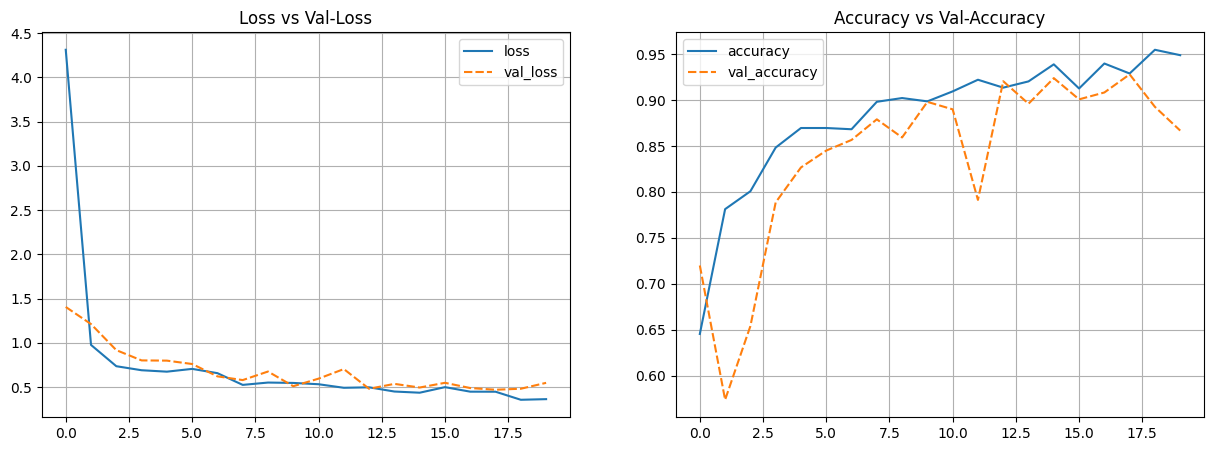

In [18]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [19]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

 Brain Tumor       0.97      0.81      0.88       503
     Healthy       0.81      0.97      0.88       418

    accuracy                           0.88       921
   macro avg       0.89      0.89      0.88       921
weighted avg       0.90      0.88      0.88       921



Model yang di train pertama ini mendapatkan nilai accuracy sebesar 0.9488 dan validation accuracy ada pada 0.8668 pada epoch yang ke 20. Hasil model training di terapkan pada data test sehingga ditemukan nilai accuracy 0.88 dan nilai f1-score pada class 'brain tumor' sebesar 0.88 dan f1-score pada class 'healthy' sebesar 0.88.

Arsitektur model pertama:
1. Menggunakan 2 convolution matrix
2. Menggunakan 1 hidden layer dengan neuron sebanyak 512 dengan activation relu, inisialisasi HeNormal dan regularisasi L2.
3. Model pertama membutuhkan waktu 4 menit 13 detik untuk train data sebanyak 20 epoch

# ANN Improvement

In [20]:
# Clear session

seed = 10
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
# Create Sequential API model

model_imp = Sequential()
model_imp.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Conv2D(64, (3,3), activation='relu'))
model_imp.add(MaxPooling2D(2, 2))
model_imp.add(Flatten())
model_imp.add(Dropout(0.5))
model_imp.add(Dense(512, activation='relu',  kernel_initializer=tf.keras.initializers.HeNormal(seed), kernel_regularizer=l2(0.01)))
model_imp.add(Dense(128, activation='relu',  kernel_initializer=tf.keras.initializers.HeNormal(seed), kernel_regularizer=l2(0.01)))
model_imp.add(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_imp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 179776)            0         
                                                                 
 dropout (Dropout)           (None, 179776)            0

In [22]:
# Train the model

%%time
history = model_imp.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
35/35 [==============================] - 12s 303ms/step - loss: 7.5944 - accuracy: 0.5956 - val_loss: 4.6835 - val_accuracy: 0.4534
Epoch 2/20
35/35 [==============================] - 10s 291ms/step - loss: 2.7435 - accuracy: 0.7536 - val_loss: 1.9143 - val_accuracy: 0.7893
Epoch 3/20
35/35 [==============================] - 11s 325ms/step - loss: 1.6416 - accuracy: 0.8333 - val_loss: 1.4224 - val_accuracy: 0.8525
Epoch 4/20
35/35 [==============================] - 10s 275ms/step - loss: 1.3120 - accuracy: 0.8659 - val_loss: 1.5153 - val_accuracy: 0.7220
Epoch 5/20
35/35 [==============================] - 10s 295ms/step - loss: 1.1535 - accuracy: 0.8682 - val_loss: 1.0996 - val_accuracy: 0.8729
Epoch 6/20
35/35 [==============================] - 11s 324ms/step - loss: 0.9936 - accuracy: 0.8899 - val_loss: 1.1962 - val_accuracy: 0.8144
Epoch 7/20
35/35 [==============================] - 11s 304ms/step - loss: 0.9363 - accuracy: 0.9049 - val_loss: 1.1396 - val_accuracy: 0.7927

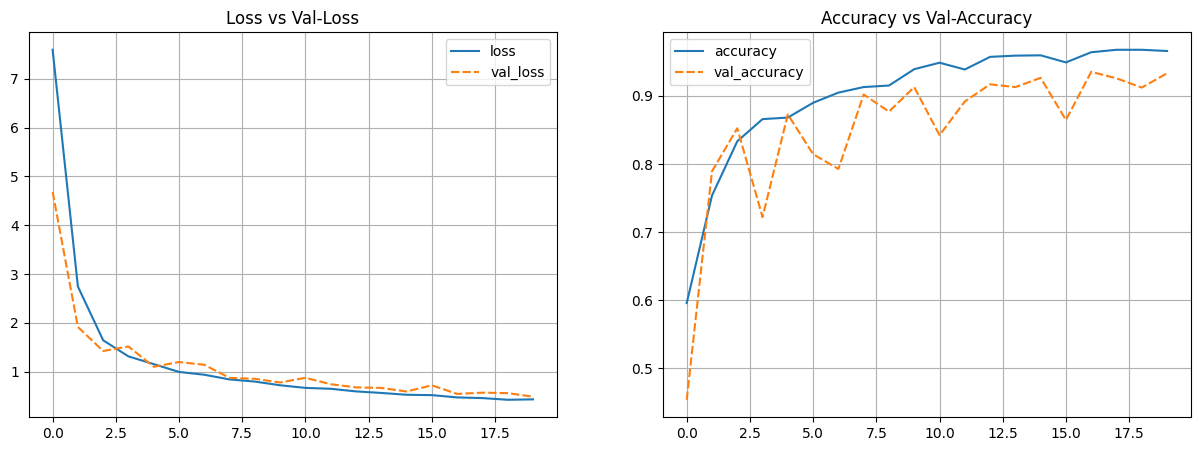

In [23]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [24]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model_imp.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

 Brain Tumor       0.92      0.95      0.94       503
     Healthy       0.94      0.91      0.92       418

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



Model Improvement mendapatkan nilai accuracy 0.9660 dan 0.9334 pada validation accuracy pada epoch yang ke 20. Hasil model training ini digunakan untuk memprediksi data test sehingga ditemukan nilai accuracy di 0.93 dengan f1-score pada class 'brain tumor' 0.94 dan f1-score pada class 'healthy' 0.92.

Arsitektur model improvement:
1. Menggunakan 2 convolution matrix
2. Menggunakan 512 neuron pada hidden layer pertama dengan activation relu, inisialisasi HeNormal dan regularisasi L2.
3. Menggunakan 128 neuron pada hidden layer kedua dengan activation relu, inisialisasi HeNormal dan regularisasi L2.
5. Model improvement membutuhkan waktu 3 menit 54 detik untuk train data sebanyak 20 epoch

Peningkatan model:
- Terjadi peningkatan performa model pertama dengan model improvement dimana nilai f1-score pada kelas brain tumor sebesar 0.88 menjadi 0.94
- Terjadi peningkatan performa model pertama dengan model improvement dimana nilai f1-score pada kelas sehat sebesar 0.88 menjadi 0.92
- Terjadi peningkatan performa model pertama dengan model improvement dimana nilai accuracy pada data test sebesar 0.88 menjadi 0.93
- Terjadi peningkatan performa model pertama dengan model improvement dimana waktu train data yang dibutuhkan pada epoch ke 20 sebesar 4 menit 13 detik menjadi 3 menit 54 detik

# Model Saving

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# Save the entire model to a keras file in Google Drive
model_imp.save('/content/drive/MyDrive/cnn_model.keras')

Arsitektur yang dipilih dalam saving ini merupakan model improvement dari model sebelumnya karena terjadi peningkatan dalam hal waktu training dan hasil accuracy dengan deskripsi arsitektur 2 convolution layer dengan 2 hidden layer.